## INP concentrations
Trying to plot INP concentration against isotherm to compare with measurements in Tobo et al. 2019

In [1]:
import sys
# Add common resources folder to path
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    polyfit, ccrs, LinearRegression, metrics
    )

from functions import (
    masked_average, interpretNS, plot_slf_isotherms, 
    add_weights, process_caliop, process_for_slf,
    noresm_slf_to_df, regress_1d
    )

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    model_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(model_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

obs_dir = 'caliop_cloudtop/'
output_dir = 'figures/'
case_dir = 'mnth15runs/'   # inconsistent label compared to jupy_test
    
# Check that each important directory can be accessed:    
access_paths = os.path.exists(obs_dir) and os.path.exists(output_dir) and os.path.exists(model_dir)
print('Can access all directory paths:', access_paths)

Running through MC2 Jupyter Hub
Can access all directory paths: True


Get observational data

In [3]:
inpobs = pd.read_csv('inp_obs/inp_obs.csv', names=['T','INP'])[:29] # 

In [4]:
def upper_fit(t):
    INP_25C = 0.14
    slope = 0.703
    inp_t = INP_25C*(slope**(t + 24.83))
    return inp_t

def lower_fit(t):
    INP_25C = 0.027
    slope = 0.5537979124908083
    inp_t = INP_25C*(slope**(t + 24.87))
    return inp_t

def mid_fit(t):
    INP_25C = 0.05
    slope = 0.7
    inp_t = INP_25C*(slope**(t + 24.87))
    return inp_t

In [5]:
inpobs['upper'] = inpobs['INP'] > mid_fit(inpobs['T'])

Text(0,0.5,'INP concentration ($l{^-1}$)')

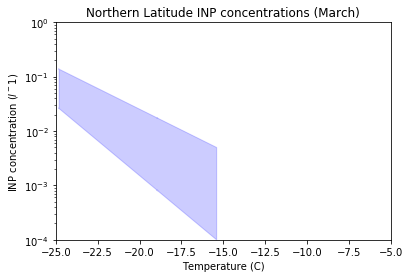

In [6]:
plt.fill_between(inpobs['T'], y1=lower_fit(inpobs['T']), y2=upper_fit(inpobs['T']),alpha=0.2, color='blue', label='Range from observations in Tobo et al., 2019')
#plt.scatter(inpobs['T'], inpobs['INP'])
plt.yscale('log')
plt.xlim((-25,-5)); #plt.ylim((1e-4,1))
plt.title('Northern Latitude INP concentrations (March)')
plt.xlabel('Temperature (C)'); plt.ylabel('INP concentration ($l{^-1}$)')

Determine the correct file paths and load the netcdf files

In [7]:
os.listdir()

['caliop_slfs',
 'inp_obs',
 '.ipynb_checkpoints',
 'caliop_cloudtop',
 'git_repos',
 'sedimentatio_dev',
 'figures',
 'NorESM_validation',
 'mnth15runs',
 'nudging_dev',
 'python-code',
 'slf_validation']

In [8]:
case = '20191230_130025_singleparam_cttest15_wbf_1_inp_1'

Add INP sum variable, then mask non-Arctic latitudes and weight by cell area to produce concentration vs. temperature relation.

In [45]:
# Load NorESM data
ds = xr.open_dataset('%s/%s/atm/hist/%s.cam.h0.0001-03.nc' % (case_dir, case, case))
if (len(ds['time']) > 1):
    try:
        ds = ds.sel(time=slice('0001-04-01', '0002-03-01'))
    except:
        ds = ds.sel(time=slice('2000-04-01', '2001-03-01'))
#        ds = _ds.isel(time=slice(3,15))
ds = add_weights(ds) # still has time here

ds['INP_sum'] = ds['NIMIX_DEP'] + ds['NIMIX_IMM'] + ds['NIMIX_CNT'] # add new variable
ds['bcINP_sum'] = ds['BCNIDEP'] + ds['BCNIIMM'] + ds['BCNICNT'] # add new variable

ds['INP_sum_TAVG'] = ds['INP_sum'].mean(dim = 'time', skipna=True)
ds['bcINP_sum_TAVG'] = ds['bcINP_sum'].mean(dim = 'time', skipna=True)

# Different resolutions, needs different masks. Remember weird mask sign convention: true=not included
mask= np.bitwise_or(ds['lat']<70, ds['lat']>90)

weight = ds['cell_weight']

inp = masked_average(ds['INP_sum_TAVG'], dim=['lat','lon'],weights=weight, mask=mask)
BCinp = masked_average(ds['bcINP_sum_TAVG'], dim=['lat','lon'],weights=weight, mask=mask)
tt = masked_average(ds['T'], dim=['lat','lon','time'],weights=weight, mask=mask)

stdev = 100*np.std(ds['INP_sum_TAVG'].sel(lat=slice(70,90)), axis=(0,1))


Plot Stuff

In [26]:
tt

<xarray.DataArray (lev: 32)>
array([235.99246742, 228.42818088, 219.42196166, 214.23621388,
       212.03398288, 210.93390544, 210.23859428, 209.73994141,
       209.47140075, 209.46963141, 209.63271827, 209.81484138,
       209.65322422, 208.72567343, 207.54232452, 207.71974119,
       209.92676894, 214.1983136 , 220.01345837, 226.82191324,
       234.13588218, 240.90316724, 246.19895899, 249.91180903,
       252.2490617 , 253.33990713, 253.72740786, 253.6857546 ,
       253.12157124, 252.02965807, 250.00776624, 247.3480846 ])
Coordinates:
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6

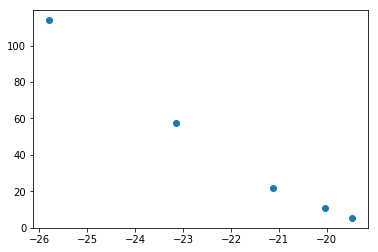

In [56]:
plt.scatter(tt[27:]-273.15, inp[27:]/1000)

Text(0,0.5,'INP concentration ($l{^-1}$)')

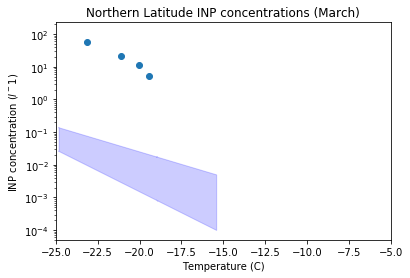

In [57]:
plt.fill_between(inpobs['T'], y1=lower_fit(inpobs['T']), y2=upper_fit(inpobs['T']),alpha=0.2, color='blue', label='Range from observations in Tobo et al., 2019')
#plt.scatter(inpobs['T'], inpobs['INP'])
plt.scatter(tt[27:]-273.15, inp[27:]/1000)
plt.yscale('log')
plt.xlim((-25,-5)); #plt.ylim((1e-4,1))
plt.title('Northern Latitude INP concentrations (March)')
plt.xlabel('Temperature (C)'); plt.ylabel('INP concentration ($l{^-1}$)')

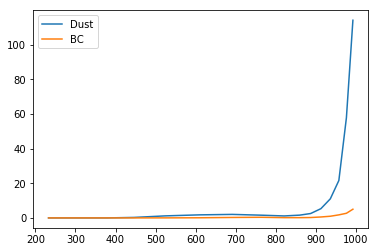

In [49]:
plt.plot(inp[15:]['lev'], inp[15:]/1000, label='Dust')
plt.plot(BCinp[15:]['lev'], BCinp[15:]/1000, label='BC')
plt.legend()

In [44]:
ds['NIMIX_IMM']

<xarray.DataArray 'NIMIX_IMM' (time: 1, lev: 32, lat: 96, lon: 144)>
[442368 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * time     (time) object 0001-04-01 00:00:00
Attributes:
    mdims:         1
    units:         #/m3
    long_name:     Activated Ice Number Concentration due to het immersion fr...
    cell_methods:  time: mean

Text(0.5,0.98,'20191230_130025_singleparam_cttest15_wbf_1_inp_1')

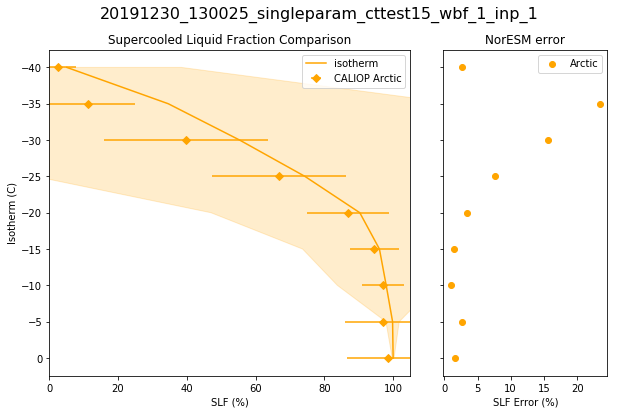

In [96]:
fig1 = plt.figure(figsize=(10,6))#constrained_layout=True)

fig1.gca().invert_yaxis()

colors = ['blue', 'orange', 'red']

for b,c in zip(bands, colors):
    if b == 'Arctic':
        f1_ax1.errorbar(df['CALIOP %s SLF' % b], df['isotherm'], xerr=2*df['CALIOP %s StDev' % b], label='CALIOP %s' % b, color = c, fmt='o', marker='D')
        f1_ax1.plot(df['NorESM %s SLF' % b], df['isotherm'], color = c) #, label=b)
        f1_ax1.fill_betweenx(df['isotherm'], df['NorESM %s SLF' % b] - 2*df['NorESM %s StDev' % b], df['NorESM %s SLF' % b] + 2*df['NorESM %s StDev' % b], alpha=0.2, color=c)

        slf_error = df['NorESM %s SLF' % b] - df['CALIOP %s SLF' % b]
        f1_ax2.scatter(slf_error, df['isotherm'], color=c, label=b)

#_r = regress_1d(isos, all_slf_clean[error])
#_s = _r.score(isos, all_slf_clean[error])
#f1_ax2.plot(_r.predict(isos), isos, color=color, label = ('$R^2 = %f$' % _s))

f1_ax1.set_xlim((0,105))
f1_ax1.legend()
f1_ax2.legend()

fig1.suptitle(case, fontsize=16)